# Stage 06: Data Preprocessing for Turtle Trading
**Project:** Turtle Trading Strategy Research  
**Author:** Panwei Hu  
**Date:** 2025-08-20

## Objectives
- Preprocess financial time series data for Turtle Trading strategy
- Handle missing values in multi-asset datasets
- Create technical indicators and features
- Normalize and scale data for backtesting
- Validate data quality for strategy implementation

## Financial Data Preprocessing Focus
- **Missing Value Handling**: Forward fill, interpolation for price data
- **Technical Features**: ATR, Donchian channels, moving averages
- **Data Alignment**: Synchronize multi-asset time series
- **Outlier Detection**: Identify data anomalies and price gaps
- **Feature Engineering**: Create signals and risk metrics for Turtle system

## Architecture
- **Preprocessing Module**: `src/preprocessing.py` - Reusable cleaning functions
- **Data Pipeline**: Load → Clean → Feature Engineering → Validation → Save


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')

# Set up project paths
PROJECT_ROOT = Path('..').resolve()
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
SRC_DIR = PROJECT_ROOT / 'src'

# Add src to Python path for imports
sys.path.append(str(SRC_DIR))

# Import our preprocessing module
try:
    from preprocessing import (
        FinancialDataProcessor, 
        TurtleDataCleaner,
        load_turtle_data,
        handle_missing_prices,
        create_technical_features,
        analyze_data_quality
    )
    print("✅ Successfully imported preprocessing module")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Please ensure preprocessing.py exists in the src/ directory")

# Ensure directories exist
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("🐢 Turtle Trading - Data Preprocessing")
print("="*50)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Raw Data: {RAW_DIR}")
print(f"Processed Data: {PROCESSED_DIR}")
print(f"Source Code: {SRC_DIR}")

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
sns.set_palette("husl")

print("✅ Environment setup complete")


✅ Successfully imported preprocessing module
🐢 Turtle Trading - Data Preprocessing
Project Root: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project
Raw Data: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/raw
Processed Data: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/processed
Source Code: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/src
✅ Environment setup complete


In [4]:
# Use the TurtleDataCleaner for complete preprocessing pipeline
print("🔧 Starting comprehensive data preprocessing pipeline...")

# Initialize the cleaner
cleaner = TurtleDataCleaner(RAW_DIR)

# Run the complete cleaning and feature engineering pipeline
df_processed = cleaner.load_and_clean(missing_method='forward_fill')

if not df_processed.empty:
    print(f"\n📊 Processing Results:")
    print(f"   Final shape: {df_processed.shape}")
    print(f"   Symbols: {df_processed['symbol'].nunique()}")
    print(f"   Date range: {df_processed['date'].min().date()} to {df_processed['date'].max().date()}")
    
    # Show the new features created
    original_cols = ['symbol', 'date', 'adj_close', 'returns', 'return_zscore', 'is_anomaly']
    new_features = [col for col in df_processed.columns if col not in original_cols]
    print(f"\n🔧 Technical Features Created ({len(new_features)}):")
    for feature in sorted(new_features):
        print(f"   • {feature}")
    
    # Show sample data
    print(f"\n📋 Sample of processed data:")
    sample_cols = ['symbol', 'date', 'adj_close', 'donchian_high_20', 'donchian_low_20', 
                   'atr_20', 'long_entry_20', 'short_entry_20']
    available_cols = [col for col in sample_cols if col in df_processed.columns]
    print(df_processed[available_cols].head(10))
    
else:
    print("❌ No data was processed. Please check data availability.")


🔧 Starting comprehensive data preprocessing pipeline...
🐢 Starting Turtle Data Cleaning Pipeline...
📊 Loading: turtle_universe_source-yfinance_assets-multi_count-18_20250820-102058.csv
✅ Loaded 9,036 records for 18 symbols
   Date range: 2023-08-21 to 2025-08-20
📊 Data Quality: 0 missing values (0.00%)
✅ Applied forward fill for missing prices
📊 Detected 13 price anomalies (Z-score > 5.0)
   Anomalies by symbol:
     DBA: 1
     EEM: 2
     EFA: 2
     FXE: 1
     HYG: 1
     IWM: 1
     QQQ: 1
     SPY: 2
     VEA: 2
🔧 Creating technical features for Turtle Trading...
✅ Created technical features for 18 symbols
✅ Turtle data cleaning pipeline completed!

📊 Processing Results:
   Final shape: (9036, 22)
   Symbols: 18
   Date range: 2023-08-21 to 2025-08-20

🔧 Technical Features Created (16):
   • asset_category
   • atr_20
   • donchian_high_20
   • donchian_high_55
   • donchian_low_20
   • donchian_low_55
   • donchian_mid_20
   • long_entry_20
   • long_exit_10
   • price_position


In [5]:
# Save Preprocessed Data
if not df_processed.empty:
    print("💾 Saving preprocessed data...")
    
    # Generate timestamp for filename
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save as Parquet for efficient storage
    output_file = PROCESSED_DIR / f'turtle_preprocessed_{timestamp}.parquet'
    df_processed.to_parquet(output_file, index=False)
    
    print(f"✅ Preprocessed data saved to: {output_file}")
    print(f"   File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")
    
    # Create and save summary statistics
    summary_file = PROCESSED_DIR / f'turtle_preprocessing_summary_{timestamp}.csv'
    
    summary_stats = []
    for symbol in df_processed['symbol'].unique():
        symbol_data = df_processed[df_processed['symbol'] == symbol]
        
        stats = {
            'symbol': symbol,
            'total_records': len(symbol_data),
            'date_range_start': symbol_data['date'].min(),
            'date_range_end': symbol_data['date'].max(),
            'avg_price': symbol_data['adj_close'].mean(),
            'avg_atr': symbol_data['atr_20'].mean() if 'atr_20' in symbol_data.columns else np.nan,
            'long_signals': symbol_data['long_entry_20'].sum() if 'long_entry_20' in symbol_data.columns else 0,
            'short_signals': symbol_data['short_entry_20'].sum() if 'short_entry_20' in symbol_data.columns else 0
        }
        summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(summary_file, index=False)
    
    print(f"✅ Summary statistics saved to: {summary_file}")
    
    # Final report
    print(f"\n🎯 PREPROCESSING COMPLETE!")
    print("="*50)
    print(f"📊 Final Dataset:")
    print(f"   Records: {len(df_processed):,}")
    print(f"   Symbols: {df_processed['symbol'].nunique()}")
    print(f"   Features: {len(df_processed.columns)}")
    print(f"   Date range: {df_processed['date'].min().date()} to {df_processed['date'].max().date()}")
    
    print(f"\n💾 Output Files:")
    print(f"   Processed data: {output_file.name}")
    print(f"   Summary stats: {summary_file.name}")
    
    print(f"\n✅ Data is ready for Turtle Trading strategy backtesting!")

else:
    print("⚠️  No processed data to save.")


💾 Saving preprocessed data...
✅ Preprocessed data saved to: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/processed/turtle_preprocessed_20250820_115447.parquet
   File size: 0.74 MB
✅ Summary statistics saved to: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/processed/turtle_preprocessing_summary_20250820_115447.csv

🎯 PREPROCESSING COMPLETE!
📊 Final Dataset:
   Records: 9,036
   Symbols: 18
   Features: 22
   Date range: 2023-08-21 to 2025-08-20

💾 Output Files:
   Processed data: turtle_preprocessed_20250820_115447.parquet
   Summary stats: turtle_preprocessing_summary_20250820_115447.csv

✅ Data is ready for Turtle Trading strategy backtesting!


In [6]:
# Save Preprocessed Data
if not df_processed.empty:
    print("💾 Saving preprocessed data...")
    
    # Generate timestamp for filename
    from datetime import datetime
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save as Parquet for efficient storage
    output_file = PROCESSED_DIR / f'turtle_preprocessed_{timestamp}.parquet'
    df_processed.to_parquet(output_file, index=False)
    
    print(f"✅ Preprocessed data saved to: {output_file}")
    print(f"   File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")
    
    # Create and save summary statistics
    summary_file = PROCESSED_DIR / f'turtle_preprocessing_summary_{timestamp}.csv'
    
    summary_stats = []
    for symbol in df_processed['symbol'].unique():
        symbol_data = df_processed[df_processed['symbol'] == symbol]
        
        stats = {
            'symbol': symbol,
            'total_records': len(symbol_data),
            'date_range_start': symbol_data['date'].min(),
            'date_range_end': symbol_data['date'].max(),
            'avg_price': symbol_data['adj_close'].mean(),
            'avg_atr': symbol_data['atr_20'].mean() if 'atr_20' in symbol_data.columns else np.nan,
            'long_signals': symbol_data['long_entry_20'].sum() if 'long_entry_20' in symbol_data.columns else 0,
            'short_signals': symbol_data['short_entry_20'].sum() if 'short_entry_20' in symbol_data.columns else 0
        }
        summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(summary_file, index=False)
    
    print(f"✅ Summary statistics saved to: {summary_file}")
    
    # Final report
    print(f"\n🎯 PREPROCESSING COMPLETE!")
    print("="*50)
    print(f"📊 Final Dataset:")
    print(f"   Records: {len(df_processed):,}")
    print(f"   Symbols: {df_processed['symbol'].nunique()}")
    print(f"   Features: {len(df_processed.columns)}")
    print(f"   Date range: {df_processed['date'].min().date()} to {df_processed['date'].max().date()}")
    
    print(f"\n💾 Output Files:")
    print(f"   Processed data: {output_file.name}")
    print(f"   Summary stats: {summary_file.name}")
    
    print(f"\n✅ Data is ready for Turtle Trading strategy backtesting!")

else:
    print("⚠️  No processed data to save.")


💾 Saving preprocessed data...
✅ Preprocessed data saved to: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/processed/turtle_preprocessed_20250820_115449.parquet
   File size: 0.74 MB
✅ Summary statistics saved to: /Users/panweihu/Desktop/Desktop_m1/NYU_mfe/bootcamp/camp4/bootcamp_bill_panwei_hu/turtle_project/data/processed/turtle_preprocessing_summary_20250820_115449.csv

🎯 PREPROCESSING COMPLETE!
📊 Final Dataset:
   Records: 9,036
   Symbols: 18
   Features: 22
   Date range: 2023-08-21 to 2025-08-20

💾 Output Files:
   Processed data: turtle_preprocessed_20250820_115449.parquet
   Summary stats: turtle_preprocessing_summary_20250820_115449.csv

✅ Data is ready for Turtle Trading strategy backtesting!


📊 Creating visualizations of preprocessed data...


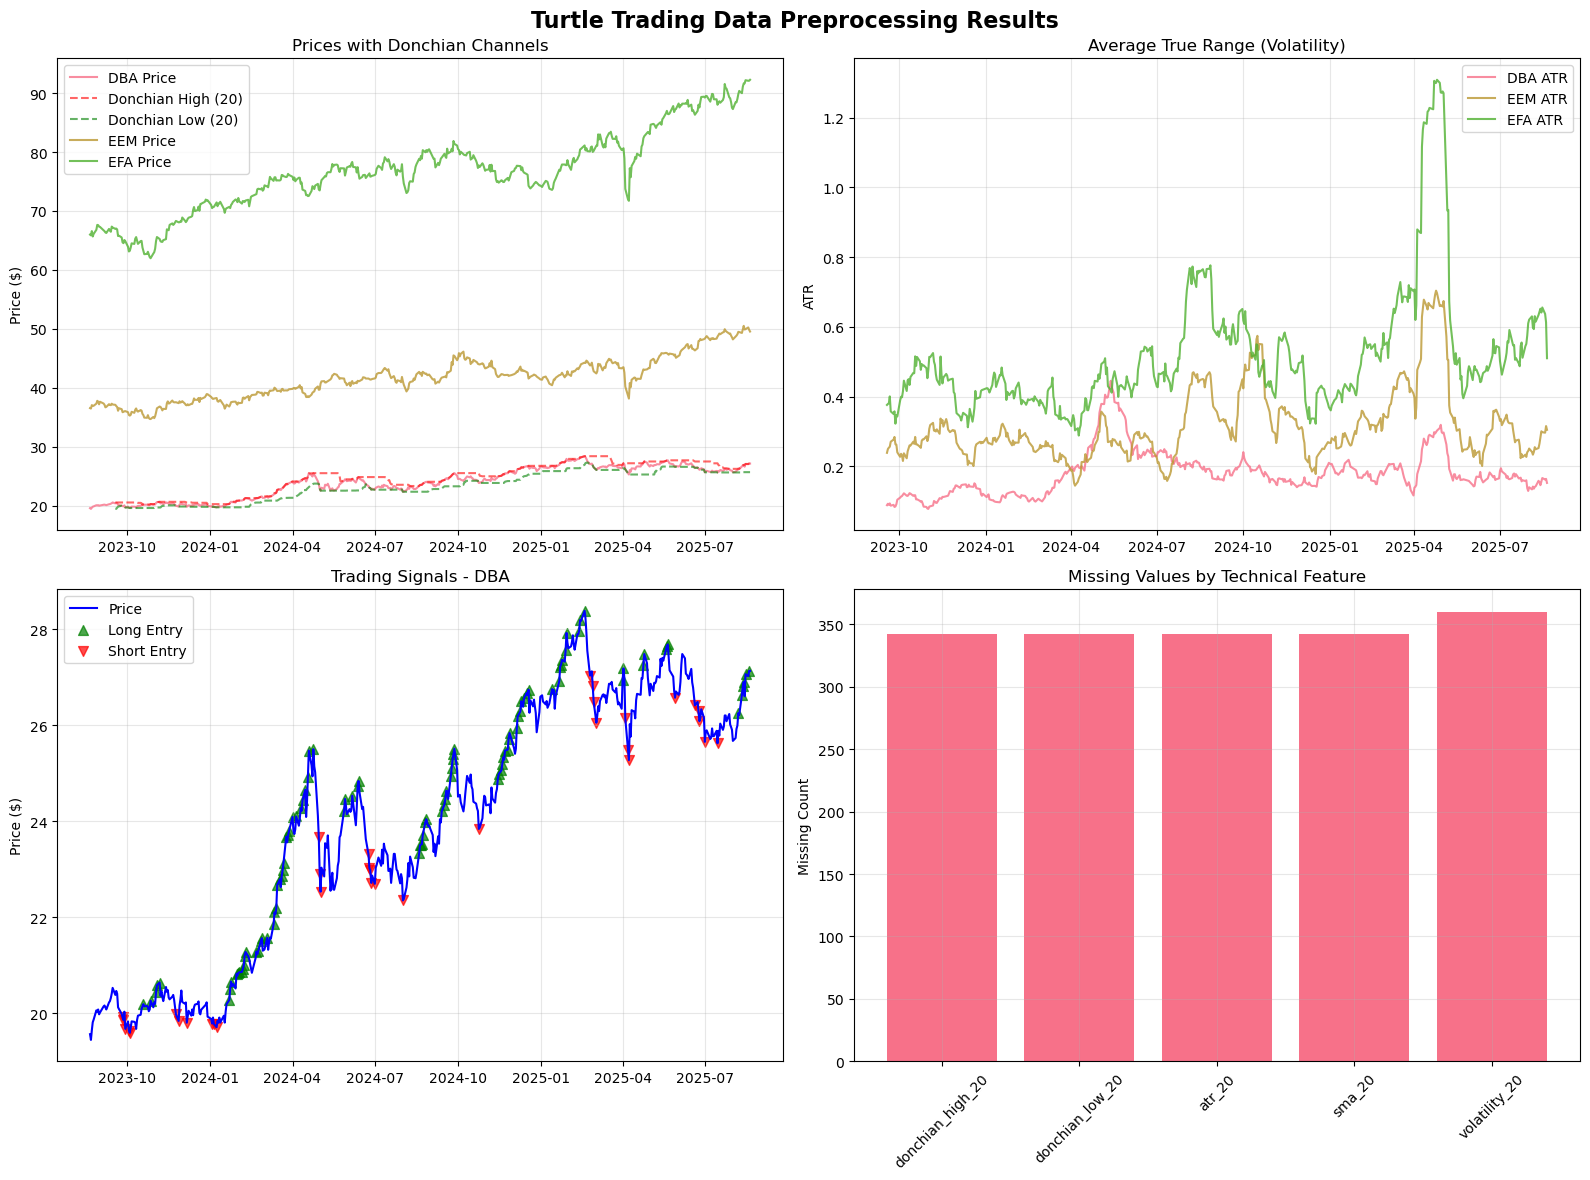


📈 Preprocessing Summary:
   Average ATR: 0.9660
   Long signals: 1402
   Short signals: 762
   Average volatility: 16.72%


In [7]:
# Visualization of Preprocessing Results
if not df_processed.empty:
    print("📊 Creating visualizations of preprocessed data...")
    
    # Select representative symbols for visualization
    sample_symbols = df_processed['symbol'].unique()[:3]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Turtle Trading Data Preprocessing Results', fontsize=16, fontweight='bold')
    
    # 1. Price and Donchian Channels
    ax1 = axes[0, 0]
    for i, symbol in enumerate(sample_symbols):
        symbol_data = df_processed[df_processed['symbol'] == symbol].copy()
        symbol_data = symbol_data.sort_values('date')
        
        ax1.plot(symbol_data['date'], symbol_data['adj_close'], 
                label=f'{symbol} Price', linewidth=1.5, alpha=0.8)
        if i == 0:  # Only show channels for first symbol to avoid clutter
            ax1.plot(symbol_data['date'], symbol_data['donchian_high_20'], 
                    'r--', alpha=0.6, label='Donchian High (20)')
            ax1.plot(symbol_data['date'], symbol_data['donchian_low_20'], 
                    'g--', alpha=0.6, label='Donchian Low (20)')
    
    ax1.set_title('Prices with Donchian Channels')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. ATR (Volatility)
    ax2 = axes[0, 1]
    for symbol in sample_symbols:
        symbol_data = df_processed[df_processed['symbol'] == symbol].copy()
        symbol_data = symbol_data.sort_values('date')
        ax2.plot(symbol_data['date'], symbol_data['atr_20'], 
                label=f'{symbol} ATR', linewidth=1.5, alpha=0.8)
    
    ax2.set_title('Average True Range (Volatility)')
    ax2.set_ylabel('ATR')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Trading Signals
    ax3 = axes[1, 0]
    symbol_data = df_processed[df_processed['symbol'] == sample_symbols[0]].copy()
    symbol_data = symbol_data.sort_values('date')
    
    ax3.plot(symbol_data['date'], symbol_data['adj_close'], 'b-', label='Price', linewidth=1.5)
    
    # Mark signals
    long_entries = symbol_data[symbol_data['long_entry_20']]
    short_entries = symbol_data[symbol_data['short_entry_20']]
    
    if not long_entries.empty:
        ax3.scatter(long_entries['date'], long_entries['adj_close'], 
                   color='green', marker='^', s=50, label='Long Entry', alpha=0.7)
    
    if not short_entries.empty:
        ax3.scatter(short_entries['date'], short_entries['adj_close'], 
                   color='red', marker='v', s=50, label='Short Entry', alpha=0.7)
    
    ax3.set_title(f'Trading Signals - {sample_symbols[0]}')
    ax3.set_ylabel('Price ($)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Feature Quality Check
    ax4 = axes[1, 1]
    
    # Show missing values by feature
    missing_data = df_processed.isnull().sum()
    technical_features = ['donchian_high_20', 'donchian_low_20', 'atr_20', 'sma_20', 'volatility_20']
    available_features = [f for f in technical_features if f in missing_data.index]
    
    if available_features:
        missing_counts = missing_data[available_features]
        ax4.bar(range(len(missing_counts)), missing_counts.values)
        ax4.set_xticks(range(len(missing_counts)))
        ax4.set_xticklabels(missing_counts.index, rotation=45)
        ax4.set_title('Missing Values by Technical Feature')
        ax4.set_ylabel('Missing Count')
        ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n📈 Preprocessing Summary:")
    if 'atr_20' in df_processed.columns:
        print(f"   Average ATR: {df_processed['atr_20'].mean():.4f}")
    if 'long_entry_20' in df_processed.columns:
        print(f"   Long signals: {df_processed['long_entry_20'].sum()}")
    if 'short_entry_20' in df_processed.columns:
        print(f"   Short signals: {df_processed['short_entry_20'].sum()}")
    if 'volatility_20' in df_processed.columns:
        print(f"   Average volatility: {df_processed['volatility_20'].mean():.2%}")

else:
    print("⚠️  No data available for visualization")
